In [1]:
import math
import os.path as osp
import sys
from collections import defaultdict
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import yaml
from tqdm import tqdm_notebook as tqdm

sys.path.insert(0, "../src/")
from data_utils import DataFourier
from pnml_min_norm_utils import PnmlMinNorm
import matplotlib.style as style
from notebook_utils import getfloat, execute_x_test_regret

style.available
# style.use("seaborn-paper")
style.use("seaborn-dark")
# plt.rc("font", family="serif")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 16

In [47]:
base_dir_list = [
    osp.join("..", "output", "20200507_134304"),
    osp.join("..", "output", "20200507_134558"),
    osp.join("..", "output", "20200507_141909"),
]

In [48]:
# Initialize output
res_list = []

# Iterate on outputs
for base_dir in base_dir_list:
    # Load configuration file
    config_path = osp.join(base_dir, ".hydra", "config.yaml")
    with open(f"{config_path}") as file:
        params = yaml.load(file, Loader=yaml.FullLoader)
    print(params)
    model_degree = params["model_degree"]
    x_train, y_train = params["x_train"], params["y_train"]

    # Load results file
    file_name = osp.join(base_dir, f"res_model_degree_{model_degree}_lamb_0.0.npy")
    loaded_list = np.load(file_name, allow_pickle=True)
    loaded_list = sorted(loaded_list, key=lambda k: k["x_test"])

    # Get results
    x_test = [res["x_test"] for res in loaded_list]
    regret = [res["regret"] for res in loaded_list]
    y_hat_erm = [res["y_hat_erm"] for res in loaded_list]
    sigma_square = params["min_sigma_square"]

    # Save to dict
    res_list.append(
        {
            "model_degree": model_degree,
            "x_test": x_test,
            "regret": regret,
            "y_hat_erm": y_hat_erm,
            "x_train": x_train,
            "y_train": y_train,
            "sigma_square": sigma_square,
            "constrain_factor": params["constrain_factor"],
            "base_dir": base_dir,
        }
    )

{'constrain_factor': 1.0, 'data_type': 'fourier', 'dx_test': 0.01, 'is_adaptive': False, 'is_multi_process': True, 'lambda': 0, 'min_sigma_square': 0.001, 'model_degree': 2, 'x_test_max': 1.0, 'x_test_min': 0, 'x_train': [0.055, 0.655, 0.855, 0.995], 'y_max': 500, 'y_min': 1e-20, 'y_num': 50000, 'y_train': [-0.1, 0.5, 0.2, 0.1]}
{'constrain_factor': 1.0, 'data_type': 'fourier', 'dx_test': 0.01, 'is_adaptive': False, 'is_multi_process': True, 'lambda': 0, 'min_sigma_square': 0.001, 'model_degree': 6, 'x_test_max': 1.0, 'x_test_min': 0, 'x_train': [0.055, 0.655, 0.855, 0.995], 'y_max': 500, 'y_min': 1e-20, 'y_num': 50000, 'y_train': [-0.1, 0.5, 0.2, 0.1]}
{'constrain_factor': 1.0, 'data_type': 'fourier', 'dx_test': 0.01, 'is_adaptive': False, 'is_multi_process': True, 'lambda': 0, 'min_sigma_square': 0.001, 'model_degree': 10, 'x_test_max': 1.0, 'x_test_min': 0, 'x_train': [0.055, 0.655, 0.855, 0.995], 'y_max': 500, 'y_min': 1e-20, 'y_num': 50000, 'y_train': [-0.1, 0.5, 0.2, 0.1]}


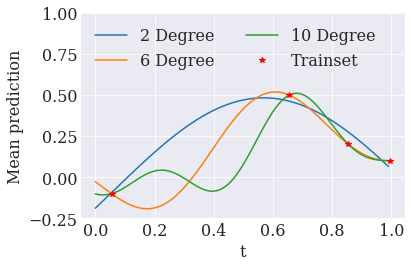

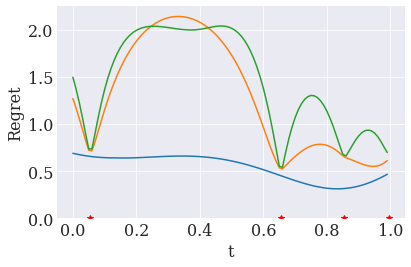

In [64]:
fig, ax = plt.subplots(1, 1)
for res in res_list:
    model_degree = res["model_degree"]
    ax.plot(res["x_test"], res["y_hat_erm"], label=r"{} Degree".format(model_degree))
ax.plot(x_train, y_train, "r*", label="Trainset")
ax.set_xlabel("t")
ax.set_ylabel("Mean prediction")
ax.grid()
ax.legend(loc=2, ncol=2)
plt.ylim(-0.25, 1.0)
plt.tight_layout()
plt.savefig(
    osp.join(
        "..", "output", "figures", "figure_pnml_linear_regression_mn_prediction.pdf"
    )
)
plt.show()

fig, ax = plt.subplots(1, 1)
for res in res_list:
    model_degree = res["model_degree"]
    ax.plot(
        res["x_test"],
        res["regret"],
        label=f"Degree {model_degree} with diffrenet constrains",
    )
ax.plot(x_train, [0] * len(y_train), "r*", label="Trainset")

ax.grid()
ax.set_ylabel("Regret")
ax.set_xlabel("t")
ax.set_ylim(bottom=0.0)
plt.tight_layout()
plt.savefig(
    osp.join("..", "output", "figures", "figure_pnml_linear_regression_mn_regret.pdf")
)
plt.show()

## Analytical pnml with constrain

In [50]:
# Get experiments params
res = res_list[2]
x_test_list = res["x_test"]
sigma_square_fix = res["sigma_square"]
print(res["model_degree"])
data_h = DataFourier(params["x_train"], params["y_train"], model_degree)
phi_train, y_train = data_h.create_train_features(), data_h.y
pnml_h = PnmlMinNorm(1.0, phi_train, y_train, 0.0, sigma_square)
theta_mn = pnml_h.theta_erm

# Compute global things
M, N = phi_train.shape
u, h_square, uh = np.linalg.svd(phi_train.dot(phi_train.T), full_matrices=True)

P_N = np.linalg.pinv(phi_train.dot(phi_train.T))
theta_mn_P_N_theta_mn = theta_mn.T.dot(P_N).dot(theta_mn)
constant_dict = {
    "P_N": P_N,
    "theta_mn_P_N_theta_mn": theta_mn_P_N_theta_mn,
    "h_square": h_square,
    "u": u,
    "theta_mn": theta_mn,
    "data_h": data_h,
    "phi_train": phi_train,
}

10


In [51]:
# Initaize genies files
genie_files = glob(osp.join(res["base_dir"], "genies_output", "genies_outputs_*.npy"))
genie_files.sort(key=lambda f: getfloat(f))

# Initialize output
regret_simulation_list = []
regret_analytical_list = []
debug_dict = defaultdict(list)

sigma_square = 1e-3
for x_test, genie_file in zip(x_test_list, genie_files):
    regret_simulation, regret_analytical, deubug_dict = execute_x_test_regret(
        x_test, model_degree, sigma_square, constant_dict, genie_file, debug_dict
    )
    regret_simulation_list.append(regret_simulation)
    regret_analytical_list.append(regret_analytical)

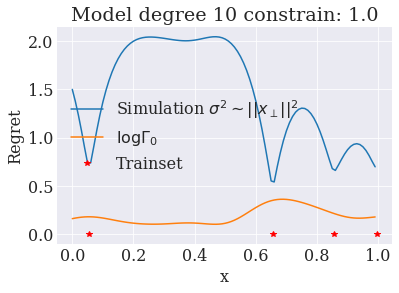

In [52]:
plt.plot(
    x_test_list,
    regret_simulation_list,
    label="Simulation $\sigma^2 \sim ||x_\perp||^2 $",
)
plt.plot(x_test_list, regret_analytical_list, label="$\log \Gamma_0$")
plt.plot(x_train, [0] * len(x_train), "r*", label="Trainset")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("Regret")
plt.title(f"Model degree {model_degree} constrain: {res['constrain_factor']}")
plt.show()

x_bot_square
sigma_square
x_P_N_x
genies_probs
y_vec


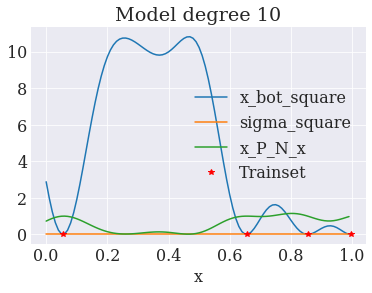

../output/20200507_141909/genies_output/genies_outputs_0.79.npy


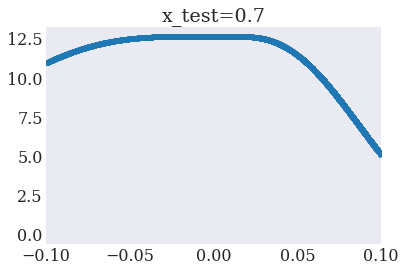

In [60]:
# Plot debug dict
for key, value in debug_dict.items():
    print(key)
    if key == "genies_probs" or key == "y_vec":
        continue
    plt.plot(x_test_list, value, label=key)
plt.plot(x_train, [0] * len(x_train), "r*", label="Trainset")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.title(f"Model degree {model_degree}")
plt.show()

# View specific test
x_test = 0.7
genie_file = [i for i in genie_files if str(x_test) in i][-1]
print(genie_file)

single_debug_dict = defaultdict(list)
regret_simulation, regret_analytical, single_debug_dict = execute_x_test_regret(
    x_test, model_degree, sigma_square, constant_dict, genie_file, single_debug_dict
)
plt.plot(
    single_debug_dict["y_vec"][0] - np.mean(single_debug_dict["y_vec"][0]),
    single_debug_dict["genies_probs"][0],
    "*",
)
plt.title(f"x_test={x_test}")
plt.xlim(-1e-1, 1e-1)
plt.show()

In [ ]:
single_debug_dict['genies_probs'][0].sum()


# Train vs Test loss

In [12]:
# User params
x_test_list = [-0.75, -0.25, 0.5]
poly_degree = 50
x_test = x_test_list[-1]
lamb = 0

In [13]:
loss_res_dict = {}
for x_test in x_test_list:
    # Data Init
    data_h = DataCosine(params["x_train"], params["y_train"])
    phi_train = data_h.create_train(poly_degree)
    phi_test = data_h.convert_point_to_features(x_test, poly_degree)

    y_train = data_h.y
    theta_erm = data_h.fit_least_squares_estimator(phi_train, y_train, lamb)
    y_hat_erm = phi_test.T.dot(theta_erm)
    max_norm = np.sum(theta_erm ** 2)

    # pNML Init
    pnml_h = PnmlMinNorm()
    pnml_h.set_erm_predictor(theta_erm)
    pnml_h.set_y_interval(params["y_min"], params["y_max"], params["dy"])
    pnml_h.min_sigma_square = params["min_sigma_square"]
    phi = pnml_h.add_test_to_train(phi_train, phi_test)

    # Iterate on y test
    train_loss_list = []
    test_loss_list = []

    y_test_list = y_hat_erm + np.linspace(-10, 10, 1000)
    for y_test in tqdm(y_test_list):
        y = np.append(y_train, y_test)
        theta = pnml_h.calc_constraint_theta(phi, y, max_norm)
        y_hat = phi_test.T.dot(theta)

        train_loss = np.mean((y_train - theta.T.dot(phi_train)) ** 2)
        test_loss = np.mean((y_test - theta.T.dot(phi_test)) ** 2)

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

    loss_res_dict[x_test] = {
        "train_loss": train_loss_list,
        "test_loss": test_loss_list,
        "y_test_list": y_test_list,
        "y_hat_erm": y_hat_erm,
        "theta_erm": theta_erm,
    }

NameError: name 'DataCosine' is not defined

In [ ]:
w, h = plt.figure().get_size_inches()
fig, axs = plt.subplots(len(loss_res_dict), 1, figsize=(w, 2 * h))
for ax, (x_test, loss_dict) in zip(axs, loss_res_dict.items()):
    ax.plot(loss_dict["y_test_list"], loss_dict["train_loss"], label="Train mean loss")
    ax.plot(loss_dict["y_test_list"], loss_dict["test_loss"], label="Test loss")
    ax.set_xlabel("Test label")
    ax.set_ylabel("Loss")
    ax.set_title("Model degree {}. x={}".format(poly_degree, x_test))
    ax.axvline(loss_dict["y_hat_erm"], label="ERM prediction", color="g", alpha=0.5)
    ax.grid()
axs[0].legend()

plt.tight_layout()
plt.show()

## ERM Loss hist

In [ ]:
poly_degree_list = [4, 50, 150]
lamb = 0.0
erm_res_dict = {}
for poly_degree in poly_degree_list:
    # Data Init
    data_h = DataCosine(params["x_train"], params["y_train"])
    phi_train = data_h.create_train(poly_degree)
    phi_test = data_h.convert_point_to_features(x_test, poly_degree)

    y_train = data_h.y
    theta_erm = data_h.fit_least_squares_estimator(phi_train, y_train, lamb)

    erm_res_dict[poly_degree] = {"theta_erm": theta_erm}

In [ ]:
bins = np.arange(0, 150)
fig, ax = plt.subplots(1, 1)
for poly_degree, single_dict in erm_res_dict.items():
    ax.plot(
        np.arange(0, len(single_dict["theta_erm"])),
        single_dict["theta_erm"] ** 2,
        "*",
        label=f"{poly_degree} Degree",
    )
    ax.set_xlabel("Weight Num")
    ax.set_ylabel("Power")
    ax.set_title("ERM Weights")
    ax.grid()
#     ax.set_yscale('log')
ax.legend()
plt.tight_layout()
plt.show()